In [ ]:
!git clone https://github.com/karuniaperjuangan/Twitter-Sentiment-Analysis-NLP-Pra-UTS.git


In [ ]:
import os
os.chdir("Twitter-Sentiment-Analysis-NLP-Pra-UTS")
%pip install -r requirements.txt

# Tugas NLP Sentiment Analysis

In [1]:
import gradio as gr
from transformers import pipeline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import gc
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import datetime as dt

2022-10-08 16:30:03.995263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 16:30:04.146434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 16:30:04.599025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib::/usr/local/cuda-11.2/targets/x86_64-linux/lib
2022-10-08 16:30:04.600070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7';

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU is available")
    print(torch.cuda.get_device_name(0))
    !nvidia-smi

GPU is available
NVIDIA GeForce RTX 3060
Sat Oct  8 16:30:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:2B:00.0  On |                  N/A |
|  0%   52C    P8     6W / 170W |    776MiB / 12288MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

# Scraping

In [ ]:
def scrape_tweets(query, max_tweets=-1,output_path="./scraper/output/" ): 
    output_path = os.path.join(output_path,dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+"-"+str(query)+".csv")
    
    tweets_list = []
    try:
        for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(query).get_items())):
            if max_tweets != -1 and i >= int(max_tweets):
                break
            tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.quoteCount, tweet.url, tweet.lang])
    except KeyboardInterrupt:
        print("Scraping berhenti atas permintaan pengguna")
    df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Likes', 'Retweets', 'Replies', 'Quotes', 'URL', 'Language'])
    df_id = df[df["Language"] == "id"]
    df_id.to_csv(output_path, index=False)
    return df_id



def remove_unnecessary_char(text):
  text = re.sub("\[USERNAME\]", " ", text)
  text = re.sub("\[URL\]", " ", text)
  text = re.sub("\[SENSITIVE-NO\]", " ", text)
  text = re.sub('  +', ' ', text)
  return text

def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text
    
def remove_nonaplhanumeric(text):
  text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
  return text

def preprocess_text(text):
  text = preprocess_tweet(text)
  text = remove_unnecessary_char(text)
  text = text.lower()
  return text

In [13]:
predict = pipeline('text-classification',
                   model='karuniaperjuangan/smsa-distilbert-indo',
                    device=0 if torch.cuda.is_available() else -1)

def analyze_df_sentiment(df, batch_size):
    text_list = list(df["Text"].astype(str).values)
    text_list_batches = [text_list[i:i+batch_size] for i in range(0,len(text_list),batch_size)] # Memisahkan berdasar batch size dengan bantuan zip
    
    predictions = []
    for batch in tqdm(text_list_batches):
        batch_predictions = predict(batch)
        predictions += batch_predictions
    df["Label"] = [pred["label"] for pred in predictions]
    df["Score"] = [pred["score"] for pred in predictions]
    
    return df

def keyword_analyzer(keyword, max_tweets, batch_size=16):
    print("Scraping tweets...")
    df = scrape_tweets(keyword, max_tweets=max_tweets)
    df["Text"] = df["Text"].apply(preprocess_text)
    print("Analyzing sentiment...")
    df = analyze_df_sentiment(df, batch_size=batch_size)
    fig = plt.figure()
    df.groupby(["Label"])["Text"].count().plot.pie(autopct="%.1f%%", figsize=(6,6))
    return fig, df[["Text", "Label", "Score"]]
 

# Web UI

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fb6f40542e0>, 'http://127.0.0.1:7867/', None)

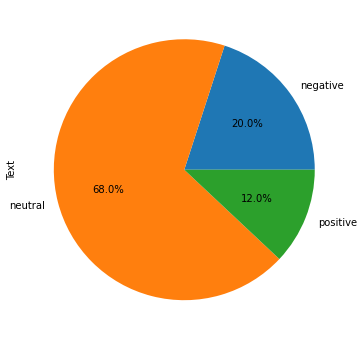

In [15]:
with gr.Blocks() as demo:
    


    gr.Markdown("""<h1 style="text-align:center">Aplikasi Sentiment Analysis Keyword Twitter </h1>""")
    
    gr.Markdown(
        """
        Aplikasi ini digunakan untuk melakukan sentimen analisis terhadap data di Twitter menggunakan model DistilBERT. Terdapat 2 mode yang dapat digunakan:
        1. Trend/Keyword: Untuk melakukan analisis terhadap semua tweet yang mengandung keyword yang diinputkan
        2. Tweet: Untuk melakukan analisis terhadap sebuah tweet yang diinputkan
        """
        
        )
    with gr.Tab("Trend/Keyword"):
        gr.Markdown("""Masukkan keyword dan jumlah maksimum tweet yang ingin diambil""")
        with gr.Blocks():
            with gr.Row():
                with gr.Column():
                    keyword_textbox = gr.Textbox(lines=1, label="Keyword")
                    max_tweets_component = gr.Number(value=-1, label="Tweet Maksimal yang akan discrape (-1 jika ingin mengscrape semua tweet)", precision=0)
                    batch_size_component = gr.Number(value=16, label="Batch Size", precision=0)
                    button = gr.Button("Submit")
                    
                plot_component = gr.Plot(label="Pie Chart")
            dataframe_component = gr.DataFrame(type="pandas", 
                                               label="Dataframe", 
                                               max_rows=(20,'fixed'), 
                                               overflow_row_behaviour='paginate', 
                                               wrap=True)

        
        
    with gr.Tab("Single Tweet"):
        gr.Interface(lambda Tweet: (predict(Tweet)[0]['label'], predict(Tweet)[0]['score']), 
                     "textbox",
                     ["label", "label"],
                     allow_flagging='never',
                     )
    
    
    gr.Markdown(
            """
            
            ## Anggota Kelompok
            
            - Karunia Perjuangan Mustadl'afin - 20/456368/TK/50498
            
            - Pramudya Kusuma Hardika - 20/460558/TK/51147
            
            """
            
        )
    
    button.click(keyword_analyzer, 
                inputs=[keyword_textbox, max_tweets_component, batch_size_component], 
                outputs=[plot_component, dataframe_component])

demo.launch(inbrowser=True)